In [1]:
#Import the packages
import pandas as pd
import numpy as np
import urllib.request # to request URLs and get the HTML from it
import requests
import string 
from bs4 import BeautifulSoup # helps you clean HTML data, remove tags and select what you want
from nltk.corpus import stopwords # ltk is a package to analyze text, dictionaries etc.
import matplotlib.pyplot as plt
from textblob import TextBlob
import re

%matplotlib inline

In [33]:
#Read the trump files
trump = pd.read_csv('trump.csv')
trump.head()

,Date,Text
0,12-27-2019 14:42:30,“Trump Stock Market rally is far outpacing pas...
1,12-26-2019 20:41:48,“Trump stock market rally is far outpacing pas...
2,12-25-2019 23:02:34,Thank you Tammy. You are doing a GREAT job! ht...
3,12-25-2019 22:29:29,Governor Gavin N has done a really bad job on ...
4,12-24-2019 12:21:33,“The Trump Administration Trump policies have ...


In [4]:
#Turn the date into datetime and sort it
trump['date']=pd.to_datetime(trump['Date'])
trump['date'] = trump['date'].dt.date
trump = trump.sort_values(by=['date'])
trump.head()

,Date,Text,date
862,01-11-2016 14:41:52,“Trump Stock Market rally is far outpacing pas...,2016-01-11
861,01-12-2016 03:34:17,“Trump stock market rally is far outpacing pas...,2016-01-12
860,01-12-2016 04:19:17,Thank you Tammy. You are doing a GREAT job! ht...,2016-01-12
859,01-14-2016 00:49:44,Governor Gavin N has done a really bad job on ...,2016-01-14
858,01-19-2016 03:44:15,“The Trump Administration Trump policies have ...,2016-01-19


In [6]:
# Load the Loughran and McDonald dictionnary
lm = pd.read_excel('LoughranMcDonald_MasterDictionary_2014.xlsx')

# get the lists of positive/negative words
lmpos = list(lm[lm.Positive!=0]['Word'])
lmneg = list(lm[lm.Negative!=0]['Word'])

In [7]:
# in these lists, we store the date, number of words, 
# number of positive words and number of negative words in each article
dates = []
nwords = []
nneg = []
npos = []
text = []


# in this block of code, we extract informations from each tweet to fill up
# the lists above
for index, row in trump.iterrows():
       
    # get all text form the dt datafame
    tweet = row['Text']
    
    # convert all words to lower case
    tweet = tweet.lower()
    
    # remove non-letters (i.e., $ %)
    natural_lang_data = ''.join([x for x in tweet if x in string.ascii_letters + '\'- '])
    
    # before processing the natural language data, we need to remove stop words.
    # stop words are words like: about, that, this, and, or, etc...
    natural_lang_data = [x for x in natural_lang_data.split() if x not in stopwords.words('english')]
    
    # finally, we store the following data: 
    nwords.append(len(natural_lang_data)) # number of words, added 
    npos.append(len([i for i in natural_lang_data if i.upper() in lmpos]))  # number of positive words after changing to upper case
    nneg.append(len([i for i in natural_lang_data if i.upper() in lmneg]))  # number of negative words
    dates.append(row['date']) # the date
    text.append(row['Text']) # the text

In [9]:
# let's store our lists in a table:
sentscore = pd.DataFrame(data={'nwords':nwords, 'npos':npos, 'nneg':nneg, 'Text':text}, index=dates)
sentscore = sentscore.reset_index()
sentscore = sentscore.rename(columns={'index':'date'})
sentscore['date'] = pd.to_datetime(sentscore['date'])
sentscore.head()

,date,nwords,npos,nneg,Text
0,2016-01-11,16,1,0,“Trump Stock Market rally is far outpacing pas...
1,2016-01-12,10,0,0,“Trump stock market rally is far outpacing pas...
2,2016-01-12,5,1,0,Thank you Tammy. You are doing a GREAT job! ht...
3,2016-01-14,20,0,2,Governor Gavin N has done a really bad job on ...
4,2016-01-19,11,0,0,“The Trump Administration Trump policies have ...


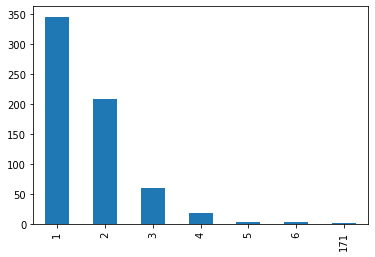

In [13]:
#Plot the number of positive tweets
npos = sentscore[sentscore['npos']>0]
npos['npos'].value_counts().plot(kind='bar')

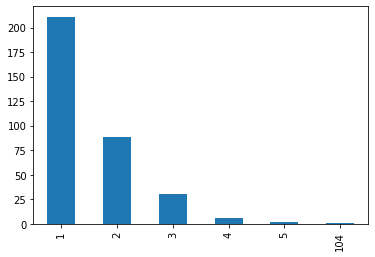

In [14]:
#Plot the number of negative tweets
nneg = sentscore[sentscore['nneg']>0]
nneg['nneg'].value_counts().plot(kind='bar')

In [15]:
# let's add a new column that stores the sentitment. See the code for the formula
sentscore['sent'] = (sentscore['npos'] - sentscore['nneg']) / sentscore['nwords']

In [17]:
from pandas.tseries.offsets import *
sentscore['date_week'] = sentscore['date'] + Week(weekday=6)
sentscore.head()

,date,nwords,npos,nneg,Text,sent,date_week
0,2016-01-11,16,1,0,“Trump Stock Market rally is far outpacing pas...,0.0625,2016-01-17
1,2016-01-12,10,0,0,“Trump stock market rally is far outpacing pas...,0.0000,2016-01-17
2,2016-01-12,5,1,0,Thank you Tammy. You are doing a GREAT job! ht...,0.2000,2016-01-17
3,2016-01-14,20,0,2,Governor Gavin N has done a really bad job on ...,-0.1000,2016-01-17
4,2016-01-19,11,0,0,“The Trump Administration Trump policies have ...,0.0000,2016-01-24


In [18]:
sentscore = sentscore.groupby(['date_week']).mean()
sent = pd.DataFrame(data=sentscore)
sent = sent[['sent']]

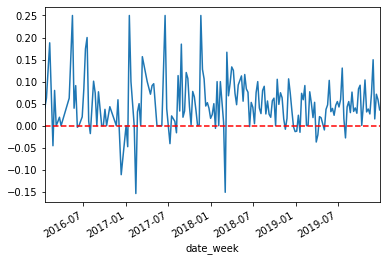

In [19]:
# as you can see, news are mostly positive... That's what sells!
sent['sent'].plot()
plt.axhline(0, c='r', ls='--')

In [20]:
# we use Quandl for data
import quandl
quandl.ApiConfig.api_key = 'xvincsYagVjR1qji2QMR'

# I chose Tsla for an example 
dj_rtn = quandl.get("EOD/DIA", collapse="weekly", start_date ="2016-01-01", end_date="2020-01-05").pct_change() #Data for the DJIA
dj_price = quandl.get("EOD/DIA", collapse="weekly")

In [21]:
#Reset the index and rename the date column as date_week
dj_rtn = dj_rtn.reset_index()
dj_rtn = dj_rtn.rename(columns={'Date':'date_week'})
dj_rtn.head()

,date_week,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2016-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-17,-0.040371,-0.034918,-0.029264,-0.021808,0.596453,inf,0.0,-0.039855,-0.034399,-0.028742,-0.021282,0.596453
2,2016-01-24,0.010360,0.004110,0.008785,0.006951,-0.629923,-1.0,0.0,0.010360,0.004110,0.008785,0.006951,-0.629923
3,2016-01-31,0.004350,0.019784,0.010713,0.022265,-0.163616,NaN,0.0,0.004350,0.019784,0.010713,0.022265,-0.163616
4,2016-02-07,0.013984,-0.002554,-0.000682,-0.014784,0.341608,NaN,0.0,0.013984,-0.002554,-0.000682,-0.014784,0.341608


In [22]:
#Merge the dow jones dateset with the sentscore dataset
dataset = pd.merge(dj_rtn, sent, on=['date_week'], how='left')
dataset.head()

,date_week,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,sent
0,2016-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-17,-0.040371,-0.034918,-0.029264,-0.021808,0.596453,inf,0.0,-0.039855,-0.034399,-0.028742,-0.021282,0.596453,0.040625
2,2016-01-24,0.010360,0.004110,0.008785,0.006951,-0.629923,-1.0,0.0,0.010360,0.004110,0.008785,0.006951,-0.629923,0.062865
3,2016-01-31,0.004350,0.019784,0.010713,0.022265,-0.163616,NaN,0.0,0.004350,0.019784,0.010713,0.022265,-0.163616,NaN
4,2016-02-07,0.013984,-0.002554,-0.000682,-0.014784,0.341608,NaN,0.0,0.013984,-0.002554,-0.000682,-0.014784,0.341608,0.188034


In [26]:
#Create new dataframe with the following columns (date_week, adjusted close, adjusted volume and the sentscore)
trumpset = dataset[['date_week', 'Adj_Close', 'Adj_Volume', 'sent']]

In [27]:
#Fill the NA with 0
trumpset = trumpset.fillna(0)
trumpset.head()

,date_week,Adj_Close,Adj_Volume,sent
0,2016-01-10,0.000000,0.000000,0.000000
1,2016-01-17,-0.021282,0.596453,0.040625
2,2016-01-24,0.006951,-0.629923,0.062865
3,2016-01-31,0.022265,-0.163616,0.000000
4,2016-02-07,-0.014784,0.341608,0.188034


In [28]:
#Finding the tweet index helps us compare the series between the returns
trumpset['tweet_rtn_index'] = trumpset['Adj_Close'] * trumpset['sent']
trumpset['tweet_vol_index'] = trumpset['Adj_Volume'] * trumpset['sent']

In [29]:
#Create a new dataframe that only has the following columns (date_week, adjusted close, adjusted volume, tweet return index, and the tweet volume index)
tweets = trumpset[['date_week','Adj_Close', 'Adj_Volume','tweet_rtn_index', 'tweet_vol_index']]
tweets.set_index('date_week').head()

,Adj_Close,Adj_Volume,tweet_rtn_index,tweet_vol_index
date_week,,,,
2016-01-10,0.000000,0.000000,0.000000,0.000000
2016-01-17,-0.021282,0.596453,-0.000865,0.024231
2016-01-24,0.006951,-0.629923,0.000437,-0.039600
2016-01-31,0.022265,-0.163616,0.000000,-0.000000
2016-02-07,-0.014784,0.341608,-0.002780,0.064234


In [30]:
#Correlation between Adj_Close and tweet Index
tweets.rank()
tweets.corr('kendall')

,Adj_Close,Adj_Volume,tweet_rtn_index,tweet_vol_index
Adj_Close,1.000000,-0.167464,0.511990,-0.083347
Adj_Volume,-0.167464,1.000000,-0.102625,0.507076
tweet_rtn_index,0.511990,-0.102625,1.000000,-0.239907
tweet_vol_index,-0.083347,0.507076,-0.239907,1.000000


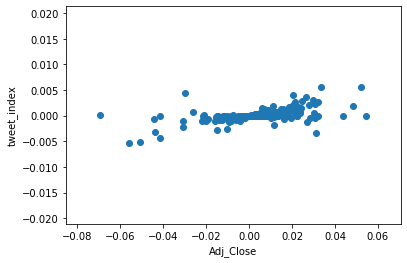

In [31]:
#Plot a scatter plot that looks at the adjusted close and tweet return index
plt.scatter(tweets['Adj_Close'], tweets['tweet_rtn_index'])
plt.xlabel('Adj_Close')
plt.ylabel('tweet_index')
plt.show()

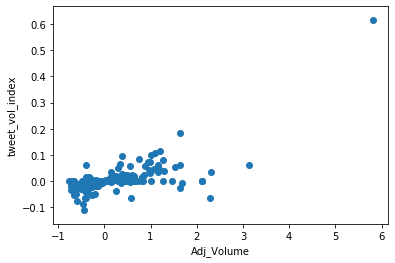

In [32]:
#Plot a scatter plot that looks at the adjusted volume and the tweet volume index
plt.scatter(tweets['Adj_Volume'], tweets['tweet_vol_index'])
plt.xlabel('Adj_Volume')
plt.ylabel('tweet_vol_index')
plt.show()

In [25]:
#p-value of tweet_index and Adj_Close

import scipy.stats as stats
stats.levene(tweets['Adj_Close'], tweets['tweet_rtn_index'])

LeveneResult(statistic=190.81248929167947, pvalue=5.460020803080139e-36)

In [26]:
#p-value of tweet_index and Adj_Volume

import scipy.stats as stats
stats.levene(tweets['Adj_Volume'], tweets['tweet_vol_index'])

LeveneResult(statistic=104.67450798953506, pvalue=4.592809888174001e-22)

In [27]:
#Lets look at a short period because there a lot fo Trump news over the past 4 years. So I choose 2019 period
new_data = tweets[tweets['date_week'].between('2019-01-01', '2019-12-29')]

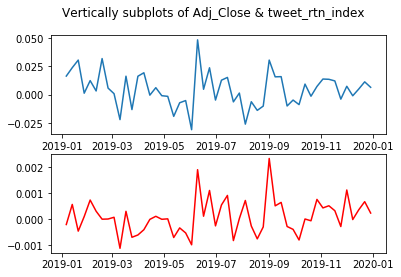

In [28]:
#Plot the adjusted close and tweet return index side by side
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically subplots of Adj_Close & tweet_rtn_index')
ax1.plot(new_data['date_week'], new_data['Adj_Close'])
ax2.plot(new_data['date_week'], new_data['tweet_rtn_index'], color='red')

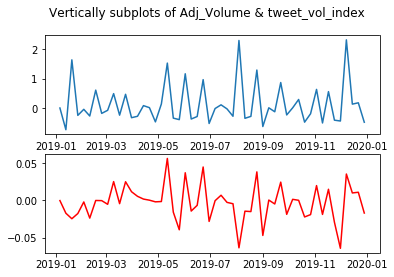

In [29]:
#Plot the adjusted close and tweet return index side by side
fig, (ax3, ax4) = plt.subplots(2)
fig.suptitle('Vertically subplots of Adj_Volume & tweet_vol_index')
ax3.plot(new_data['date_week'], new_data['Adj_Volume'])
ax4.plot(new_data['date_week'], new_data['tweet_vol_index'], color='red')

In [30]:
tweets['Ret_lag'] = tweets['Adj_Close'].shift()

In [31]:
#Create the regression
import statsmodels.formula.api as smf


reg = smf.ols('Adj_Close~tweet_rtn_index+tweet_vol_index+Ret_lag', data=tweets).fit()

In [32]:
#Regression 
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj_Close   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     33.33
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.42e-17
Time:                        14:41:40   Log-Likelihood:                 588.69
No. Observations:                 208   AIC:                            -1169.
Df Residuals:                     204   BIC:                            -1156.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0024      0.001      2.343      0.020       0.000       0.004
tweet_rtn_index     7.7219      0.792      9.749      0.000       6.160       9.284
tweet_vol_index    -0.0021      0.019     -0.112      0.911      -0.039       0.035
Ret_lag            -0.0479      0.058     -0.830      0.407      -0.162       0.066
==============================================================================
Omnibus:                       51.457   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.989
Skew:                          -0.646   Prob(JB):                     2.09e-90
Kurtosis:                       9.781   Cond. No.                         793.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Build Predictive Model: Linear Regression

In [33]:
# Features involved in the prediction
dfX = tweets[['tweet_vol_index', 'tweet_rtn_index', 'Adj_Volume']]

# The variable that is being predicted
dfY = tweets['Adj_Close']

In [34]:
##Cross Validation

#Import the module for cross validation
from sklearn.model_selection import train_test_split

#Break the data between train and test
X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size=0.2, random_state=0)

In [35]:
# Create linear regression! (Yay!)

from sklearn.linear_model import LinearRegression

# Create regressor object
linearRegression = LinearRegression()

# Fit data
linearRegression.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
#Create a prediction table on the test set
Y_predict = linearRegression.predict(X_test)

#Print
print(Y_predict)

[ 0.0048197   0.00393     0.00068059  0.00441241  0.0026818  -0.0032003
  0.03132821  0.02556294  0.00447249  0.00111873  0.00429502  0.00178579
 -0.00043755 -0.00477284  0.0035876   0.00527125  0.00602023  0.00594911
 -0.00279162 -0.01603573  0.00295072  0.00580824  0.0137056   0.00659621
  0.00692351  0.00630415  0.00097975  0.00538685 -0.01208568 -0.00304244
  0.01142274  0.00457853  0.00735427 -0.00998327 -0.00935826  0.00604363
 -0.00065578  0.01478769 -0.006142   -0.00064179  0.02294388  0.00382377]


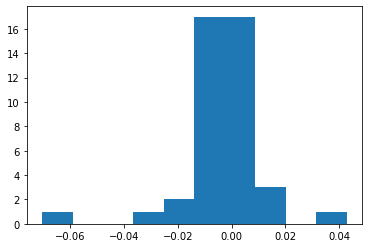

In [37]:
#Check the distribution of the residual
residual = Y_test - Y_predict
plt.hist(residual)
plt.show()

In [38]:
import scipy

scipy.stats.normaltest(residual)
#It is not normal distributed!

NormaltestResult(statistic=36.21158061112045, pvalue=1.3701091913675239e-08)

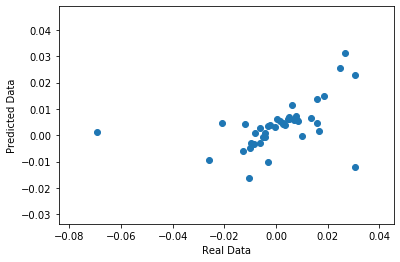

In [39]:
#Scatter Plot showing an a positive correlation
plt.scatter(Y_test, Y_predict)
plt.xlabel('Real Data')
plt.ylabel('Predicted Data')
plt.show()

In [45]:
DiffSumResiduals = (Y_predict - np.mean(Y_test))**2
DiffSumActual = (Y_test - np.mean(Y_test))**2
rSquared2 = DiffSumResiduals.sum()/DiffSumActual.sum()

print('R^2:', str(rSquared2))
print('The R^2 is between 0.3-0.5, the model is considerd moderate predictor of the returns')

R^2: 0.3100805998763911
The R^2 is between 0.3-0.5, the model is considerd moderate predictor of the returns
